---
Let's load up our generated models and make some predictions.

First we'll grab a synthetic image to analyze:

---

2-green-empty-oval-27.png


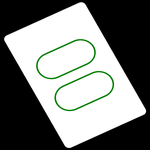

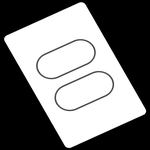

In [3]:
import os
import random
from IPython import display


rgb_directory = 'resized-images'
greyscaled_directory = 'greyscaled-images'
random.seed(2)
image_filename = random.choice(os.listdir(rgb_directory))
print image_filename

rgb_filepath = os.path.join(rgb_directory, image_filename)
display.display(display.Image(filename=rgb_filepath))
greyscaled_filepath = os.path.join(greyscaled_directory, image_filename)
display.display(display.Image(filename=greyscaled_filepath))

---
Convert the images into arrays, one greyscaled, one RGB.  Some ugly gymnastics are required to get inputs into the right rank and datatype.

---

In [4]:
import numpy as np
from PIL import Image


def convert_to_greyscaled_pixel_data(path):
  greyscaled_image = Image.open(path)
  return np.array(
    [pixel / 255. for row in np.array(greyscaled_image) for pixel in row]).astype(np.float32).reshape((1, -1))

greyscaled_data = convert_to_greyscaled_pixel_data(greyscaled_filepath)
    

def convert_to_rgb_pixel_data(path):
  rgb_image = Image.open(path)
  number_of_channels = np.array(rgb_image).shape[2]
  pixel_data = [pixel for row in np.array(rgb_image) for pixel in row]
  if number_of_channels == 4:
    rgb_data = np.array([(r, g, b) for r, g, b, _ in pixel_data]).flatten().astype(np.float32).reshape((1, -1))
  elif number_of_channels == 3:
    rgb_data = np.array(pixel_data).flatten().astype(np.float32).reshape((1, -1))
  return rgb_data

rgb_data = convert_to_rgb_pixel_data(rgb_filepath)

---
We'll start by evaluating the number of shapes.

---

In [6]:
import tensorflow as tf


def estimate_number_of_shapes(greyscaled_data):
  card_width, card_height = 150, 150
  hidden_layer_size = 1024
  checkpoint_filepath = '/tmp/detect-number-model.ckpt'

  # Setup tf variables.
  graph = tf.Graph()
  with graph.as_default():
    hidden_weights = tf.Variable(tf.truncated_normal([card_width*card_height, hidden_layer_size]), name='hidden_weights')
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]), name='hidden_biases')
    output_weights = tf.Variable(tf.truncated_normal([hidden_layer_size, 3]), name='output_weights')
    output_biases = tf.Variable(tf.zeros([3]), name='output_biases')

  with tf.Session(graph=graph) as session:
    # Load the model.
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_filepath)
    # Predict!
    hidden_layer = tf.nn.relu(tf.matmul(greyscaled_data, hidden_weights) + hidden_biases)
    logits = tf.matmul(hidden_layer, output_weights) + output_biases
    estimate = tf.nn.softmax(logits)
    result = estimate.eval()[0]

  labels = (1, 2, 3)
  for i in range(len(labels)):
    if result[i]:
      return labels[i]

      
result = estimate_number_of_shapes(greyscaled_data)
print 'estimated number of shapes: %s' % result

estimated number of shapes: 2


---
We can separately guess the card's color.

---

In [7]:
def estimate_color(rgb_data):
  card_width, card_height, card_channels = 150, 150, 3
  first_hidden_layer_size, second_hidden_layer_size = 512, 512
  checkpoint_filepath = '/tmp/detect-color-model.ckpt'

  graph = tf.Graph()
  with graph.as_default():
    first_hidden_weights = tf.Variable(
      tf.truncated_normal([card_width*card_height*card_channels, first_hidden_layer_size]), name='first_hidden_weights')
    first_hidden_biases = tf.Variable(
      tf.zeros([first_hidden_layer_size]), name='first_hidden_biases')
    second_hidden_weights = tf.Variable(
      tf.truncated_normal([first_hidden_layer_size, second_hidden_layer_size]), name='second_hidden_weights')
    second_hidden_biases = tf.Variable(
      tf.zeros([second_hidden_layer_size]), name='second_hidden_biases')
    output_weights = tf.Variable(
      tf.truncated_normal([second_hidden_layer_size, 3]), name='output_weights')
    output_biases = tf.Variable(
      tf.zeros([3]), name='output_biases')

  with tf.Session(graph=graph) as session:
    # Load the model.
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_filepath)
    # Predict!
    first_hidden_layer = tf.nn.relu(tf.matmul(rgb_data, first_hidden_weights) + first_hidden_biases)
    second_hidden_layer = tf.nn.relu(tf.matmul(first_hidden_layer, second_hidden_weights) + second_hidden_biases)
    logits = tf.matmul(second_hidden_layer, output_weights) + output_biases
    estimate = tf.nn.softmax(logits)
    result = estimate.eval()[0]

  labels = ('red', 'green', 'purple')
  for i in range(len(labels)):
    if result[i]:
      return labels[i]

      
result = estimate_color(rgb_data)
print 'estimated color: %s' % result

estimated color: green


---
How about a real image?

---

In [8]:
input_directory = 'irl-images'
irl_image_filename = 'irl-3-purple-empty-diamond.jpg'
irl_image_filepath = os.path.join(input_directory, irl_image_filename)

---
Let's make it square and scale it down.  We also need a greyscale version.

---

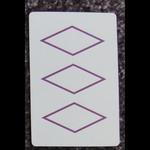

In [9]:
image = Image.open(irl_image_filepath)
largest_dimension = max((image.width, image.height))
new_image = Image.new('RGB', (largest_dimension, largest_dimension), (0, 0, 0))
left_padding = (largest_dimension - image.width) / 2
top_padding = (largest_dimension - image.height) / 2
new_image.paste(image, (left_padding, top_padding))

card_width, card_height = 150, 150
resized_image = new_image.resize((card_width, card_height), resample=Image.ANTIALIAS)

output_directory = 'irl-resized-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
output_filepath = os.path.join(output_directory, irl_image_filename)
resized_image.save(output_filepath)
display.display(display.Image(filename=output_filepath))

# Save a greyscale copy too.
output_directory = 'irl-greyscaled-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
output_filepath = os.path.join(output_directory, irl_image_filename)
greyscaled_image = resized_image.convert('L')
greyscaled_image.save(output_filepath)

---
Convert to pixel data and make an estimate.

---

In [10]:
irl_resized_filepath = os.path.join('irl-resized-images', irl_image_filename)
irl_greyscaled_filepath = os.path.join('irl-greyscaled-images', irl_image_filename)

irl_greyscaled_data = convert_to_greyscaled_pixel_data(irl_greyscaled_filepath)
irl_rgb_data = convert_to_rgb_pixel_data(irl_resized_filepath)

result = estimate_number_of_shapes(irl_greyscaled_data)
print 'estimated number of shapes: %s' % result
      
result = estimate_color(irl_rgb_data)
print 'estimated color: %s' % result

estimated number of shapes: 3
estimated color: green
